
# Лабаораторная работа №1: Аудио EDA и характеристики сигнала

**Цель:** научиться загружать аудиодатасеты, читать и интерпретировать метаданные, вычислять базовые характеристики аудиосигнала и строить визуализации (waveform, спектр, Mel/Log‑Mel).  
**Формат:** заполнить `TODO`‑ячейки. Ячейки с `raise NotImplementedError` необходимо заменить вашим кодом.

**Требования по оформлению графиков:** используйте `matplotlib` (без seaborn), один график на фигуру, не задавайте кастомные цвета.

**Зависимости:** `datasets[audio]`, `librosa`, `numpy`, `matplotlib`, `soundfile`, `tqdm`.


In [1]:

# === Установка и импорт (при необходимости раскомментируйте установки) ===
# !pip install -q datasets[audio] librosa soundfile matplotlib numpy tqdm

import os, json, random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from datasets import load_dataset, Audio
import librosa, librosa.display
import soundfile as sf

import warnings;

warnings.filterwarnings('ignore')

SEED = 42
random.seed(SEED);
np.random.seed(SEED)


/Users/velimirhlebnikov/МТУСИ/project_prcatice/speech-intencity/audio-events-detection/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



## Задание 1. Выбор и загрузка датасета(ов)

**Варианты:**
- Речь (например, `PolyAI/minds14`, любая локаль).
- Звуки окружения (любой датасет на HF Hub или локальная папка WAV/FLAC).

**Что сделать:**
1. Указать идентификатор/путь датасета.
2. Загрузить сплит (например, `train` или подвыборку).
3. Показать структуру фич и пример записи.


In [2]:

# TODO-1.1: укажите идентификатор (или оставьте None для локальной загрузки)
DATASET_ID = "PolyAI/minds14"  # замените при необходимости
DATASET_CONFIG = "en-AU"  # например: en-AU, ru-RU и т.д. (или None)
DATASET_SPLIT = "train"  # можно взять 'train[:200]' для подвыборки

# TODO-1.2: загрузка датасета через 🤗 Datasets
try:
    ds = load_dataset(DATASET_ID, name=DATASET_CONFIG, split=DATASET_SPLIT)
except Exception as e:
    print("Не удалось загрузить датасет через load_dataset:", e)
    ds = None  # Реализуйте локальную загрузку ниже при необходимости

# TODO-1.3 (опц.): локальная загрузка как Dataset из списка путей/метаданных
# Подсказка: соберите dict c полями 'path' и 'audio' (array, sampling_rate)
# raise NotImplementedError("Реализуйте локальную загрузку при необходимости.")


In [3]:

# TODO-1.4: выведите схему фич и пример
def preview(ds, n=1):
    if ds is None:
        print("Dataset is None")
        return
    print(ds)
    print("Пример:")
    print(ds[0])


preview(ds, n=1)


Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 654
})
Пример:
{'path': 'en-AU~PAY_BILL/response_4.wav', 'audio': {'path': 'response_4.wav', 'array': array([ 0.        ,  0.00024414, -0.00024414, ..., -0.00024414,
        0.00024414,  0.0012207 ], shape=(62415,)), 'sampling_rate': 8000}, 'transcription': 'I would like to pay my electricity bill using my card can you please assist', 'english_transcription': 'I would like to pay my electricity bill using my card can you please assist', 'intent_class': 13, 'lang_id': 2}



## Задание 2. Базовые характеристики аудиосигнала

**Что посчитать для N примеров:**
- Частота дискретизации (SR), длительность (с), количество каналов.
- Пиковый уровень (max |x|), RMS‑уровень, оценка динамического диапазона (приближенно).
- Коэффициент клиппинга (% сэмплов с |x|≈1.0 при float или на границе int).
- Zero‑Crossing Rate (ZCR), спектральный центроид и полосa (bandwidth).
- (Опционально) Оценка SNR при простой модели шума (на ваш выбор).

**Вывести:**
- Сводную таблицу (словари/списки), а также агрегаты: mean/median/p95.


In [4]:

# TODO-2.1: реализуйте функции вычисления характеристик
def num_channels(arr: np.ndarray) -> int:
    """Возвращает количество каналов (1 для моно)."""
    if arr.ndim == 1: return 1

    if arr.ndim == 2:
        return arr.shape[1] if arr.shape[1] < arr.shape[0] else arr.shape[0]
    raise ValueError("invalid array shape")


def peak_level(arr: np.ndarray) -> float:
    return np.max(np.abs(arr))


def rms_level(arr: np.ndarray) -> float:
    return np.sqrt(np.mean(np.square(arr)))


def clipping_ratio(arr: np.ndarray, thr: float = 0.999) -> float:
    clipping_samples = np.sum(np.abs(arr) >= thr)

    ratio = clipping_samples / len(arr)

    return ratio


def zero_crossing_rate(arr: np.ndarray) -> float:
    signs = np.sign(arr)
    zero_crossings = np.sum(signs[1:] != signs[:-1])
    return zero_crossings / len(arr)


def spectral_stats(arr: np.ndarray, sr: int):
    """Спектральные признаки: центроид и полоса (bandwidth)."""
    centroid = librosa.feature.spectral_centroid(y=arr, sr=sr)

    bandwidth = librosa.feature.spectral_bandwidth(y=arr, sr=sr)

    return np.mean(centroid), np.mean(bandwidth)


def duration_seconds(arr: np.ndarray, sr: int) -> float:
    return len(arr) / float(sr)


In [5]:

# TODO-2.2: пройдите по подвыборке датасета и соберите метрики
N = 200  # размер подвыборки для оценки
metrics = []

if ds is not None:
    idxs = np.random.choice(len(ds), size=min(N, len(ds)), replace=False)
    for i in tqdm(idxs, desc="Computing metrics"):
        ex = ds[int(i)]
        aud = ex.get("audio", {})
        arr, sr = aud.get("array"), aud.get("sampling_rate")
        if arr is None or sr is None:
            continue
        # Если многоканальный — приведите к моно для метрик или учитывайте каналы отдельно
        # TODO: при необходимости to_mono
        m = {
            "sr": sr,
            "dur_s": duration_seconds(arr, sr),
            "channels": num_channels(arr),
            "peak": peak_level(arr),
            "rms": rms_level(arr),
            "clip_ratio": clipping_ratio(arr),
            "zcr": zero_crossing_rate(arr),
        }
        sc = spectral_stats(arr, sr)  # ожидается dict с ключами, например, 'centroid', 'bandwidth'
        if isinstance(sc, dict): m.update(sc)
        metrics.append(m)

metrics[:3]  # просмотр первых строк


Computing metrics: 100%|██████████| 200/200 [00:01<00:00, 185.85it/s]


[{'sr': 8000,
  'dur_s': 6.130125,
  'channels': 1,
  'peak': np.float64(0.8553466796875),
  'rms': np.float64(0.11050476662861407),
  'clip_ratio': np.float64(0.0),
  'zcr': np.float64(0.3334556799412736)},
 {'sr': 8000,
  'dur_s': 19.285375,
  'channels': 1,
  'peak': np.float64(0.6365966796875),
  'rms': np.float64(0.07038895215030415),
  'clip_ratio': np.float64(0.0),
  'zcr': np.float64(0.193754334566997)},
 {'sr': 8000,
  'dur_s': 6.62,
  'channels': 1,
  'peak': np.float64(0.3162841796875),
  'rms': np.float64(0.02426519857680162),
  'clip_ratio': np.float64(0.0),
  'zcr': np.float64(0.26334969788519635)}]

In [6]:

# TODO-2.3: агрегируйте метрики и выведите сводку (mean/median/p95)
import numpy as np


def agg(values):
    if not values: return {"mean": None, "median": None, "p95": None}
    arr = np.array(values, dtype=float)
    return {"mean": float(np.mean(arr)), "median": float(np.median(arr)), "p95": float(np.percentile(arr, 95))}


def summarize(metrics):
    keys = [k for k in metrics[0].keys() if isinstance(metrics[0][k], (int, float))]
    summary = {}
    for k in keys:
        summary[k] = agg([m[k] for m in metrics if m.get(k) is not None])
    return summary


if metrics:
    summary = summarize(metrics)
    print(json.dumps(summary, indent=2, ensure_ascii=False))
else:
    print("Нет метрик для сводки — проверьте загрузку/вычисления.")


{
  "sr": {
    "mean": 8000.0,
    "median": 8000.0,
    "p95": 8000.0
  },
  "dur_s": {
    "mean": 8.31026875,
    "median": 6.315250000000001,
    "p95": 19.298106249999993
  },
  "channels": {
    "mean": 1.0,
    "median": 1.0,
    "p95": 1.0
  },
  "peak": {
    "mean": 0.589521484375,
    "median": 0.6053466796875,
    "p95": 0.9506591796874995
  },
  "rms": {
    "mean": 0.05825574031868222,
    "median": 0.05396815424434677,
    "p95": 0.11829728493151118
  },
  "clip_ratio": {
    "mean": 0.0,
    "median": 0.0,
    "p95": 0.0
  },
  "zcr": {
    "mean": 0.27278230643939955,
    "median": 0.2762841174309937,
    "p95": 0.36552465210584323
  }
}



## Задание 3. Визуализация: waveform, спектр, Mel/Log‑Mel

**Что сделать:**
1. Построить waveform для нескольких примеров (ось x — время, y — амплитуда).
2. STFT‑спектрограмму в dB (логарифмическая шкала по амплитуде).
3. Mel‑спектрограмму и Log‑Mel при разных параметрах (`n_fft`, `hop_length`, `n_mels`, `fmax`, `htk/slaney`).
4. Сравнить как минимум 3 конфигурации и описать наблюдения в тексте.


In [7]:

# TODO-3.1: вспомогательные функции визуализации
def plot_waveform(arr, sr, title="Waveform"):
    plt.figure()
    librosa.display.waveshow(arr, sr=sr)
    plt.title(title);
    plt.xlabel("Time");
    plt.ylabel("Amplitude");
    plt.show()


def plot_spectrogram_db(arr, sr, n_fft=2048, hop_length=512, title="Spectrogram (dB)"):
    import numpy as np
    D = librosa.stft(arr, n_fft=n_fft, hop_length=hop_length)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    plt.figure()
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz')
    plt.title(title);
    plt.colorbar();
    plt.show()


def plot_mel_logmel(arr, sr, n_fft=2048, hop_length=512, n_mels=80, fmax=None, htk=False, title_prefix="Mel"):
    import numpy as np
    mel = librosa.feature.melspectrogram(y=arr, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmax=fmax,
                                         htk=htk)
    logmel = librosa.power_to_db(mel, ref=np.max)
    plt.figure()
    librosa.display.specshow(logmel, sr=sr, x_axis='time', y_axis='mel', hop_length=hop_length)
    plt.title(f"{title_prefix}: log-Mel (n_mels={n_mels}, htk={htk})");
    plt.colorbar();
    plt.show()
    return mel, logmel


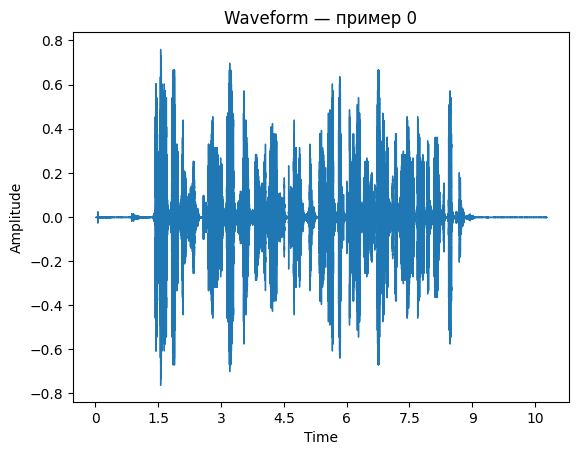

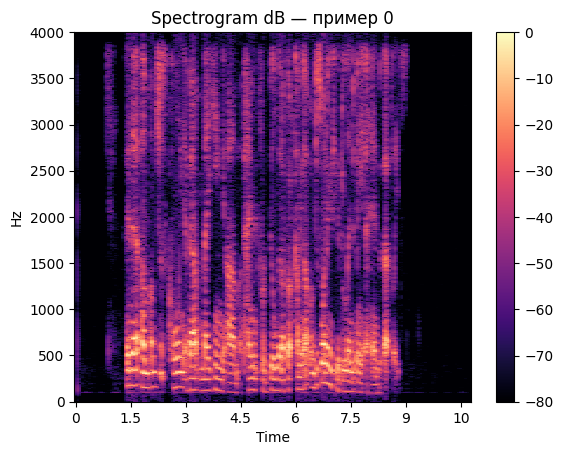

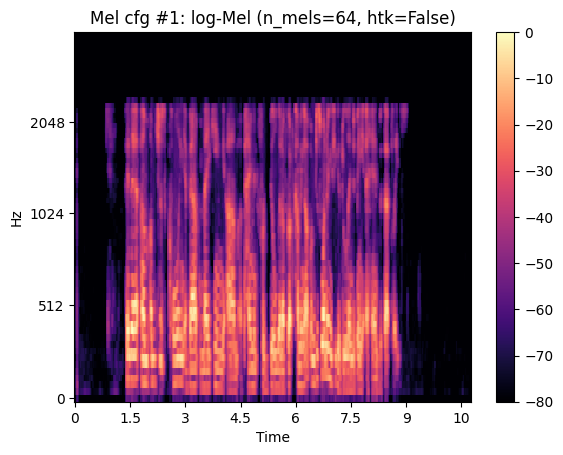

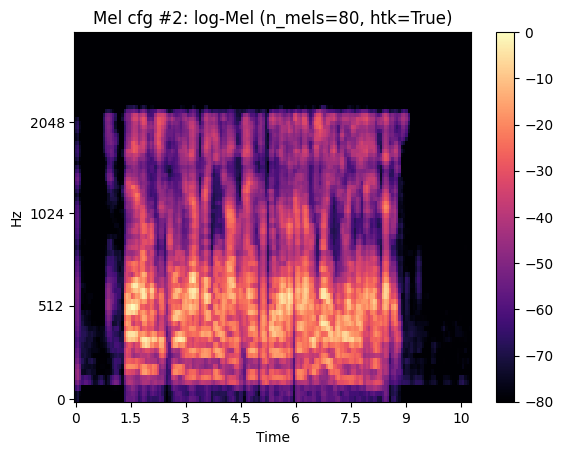

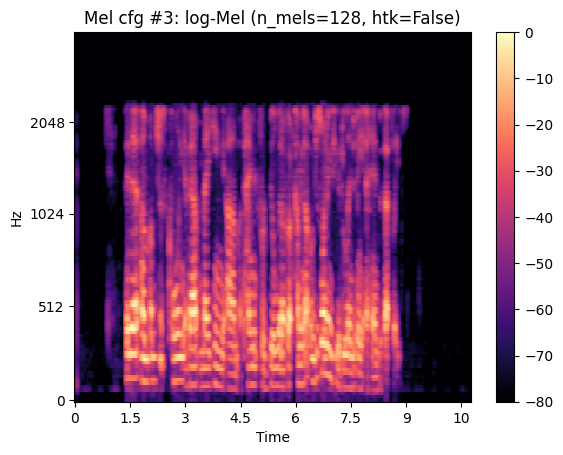

In [8]:

# TODO-3.2: выберите 1-2 примера и постройте все типы визуализаций
if ds is not None and len(ds) > 0:
    ex = ds[7]
    arr, sr = ex['audio']['array'], ex['audio']['sampling_rate']
    plot_waveform(arr, sr, title="Waveform — пример 0")
    plot_spectrogram_db(arr, sr, n_fft=2048, hop_length=512, title="Spectrogram dB — пример 0")
    # Mel/Log‑Mel: сравнение конфигураций
    cfgs = [
        dict(n_fft=1024, hop_length=256, n_mels=64, fmax=8000, htk=False),
        dict(n_fft=2048, hop_length=512, n_mels=80, fmax=8000, htk=True),
        dict(n_fft=2048, hop_length=256, n_mels=128, fmax=8000, htk=False),
    ]
    for i, cfg in enumerate(cfgs):
        plot_mel_logmel(arr, sr, **cfg, title_prefix=f"Mel cfg #{i + 1}")
else:
    print("Датасет пуст или не загружен.")



## Задание 4. Передискретизация и сравнение (resampling)

**Что сделать:**
1. Передискретизировать сигнал до 16 kHz (если исходно другой SR) и сравнить waveform/спектры до/после.
2. Посчитать Nyquist‑частоту для обеих SR и обсудить, какие частоты потенциально теряются.
3. Оценить влияние `hop_length` при фиксированном `n_fft` на временное/частотное разрешение.


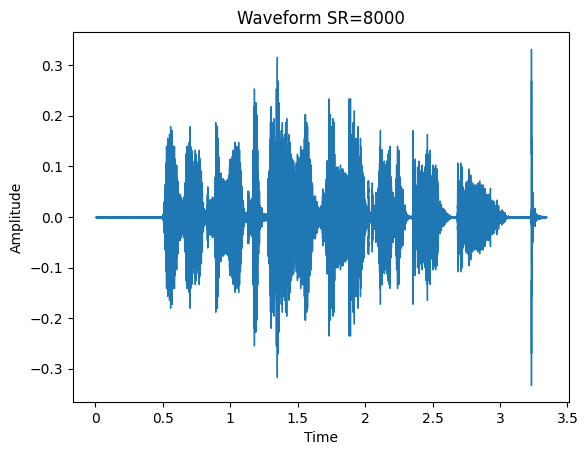

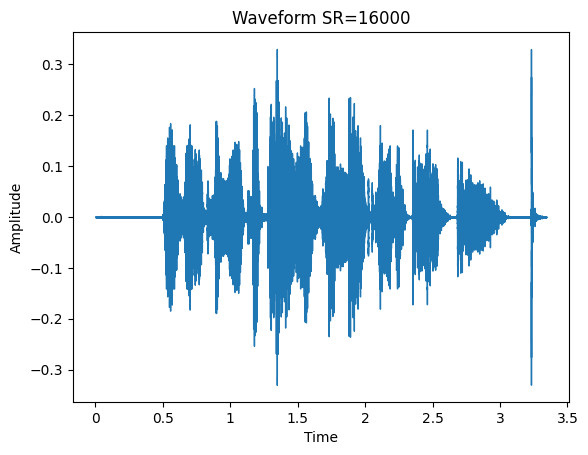

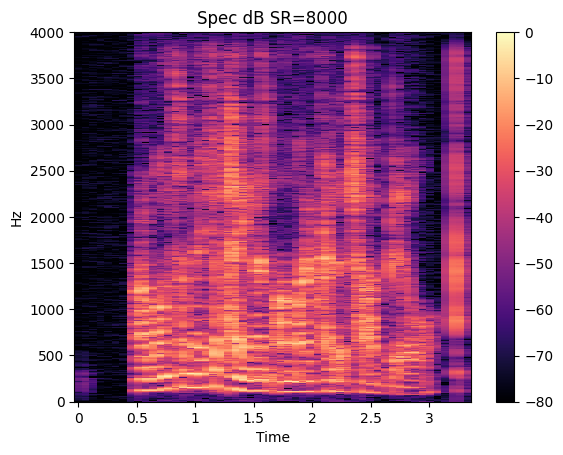

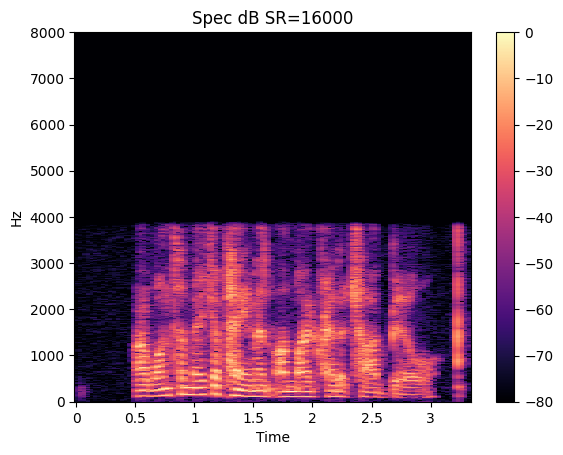

Nyquist исходный: 4000.0 Hz; после: 8000.0 Hz


In [12]:

# TODO-4.1: ресемплинг и сравнение
TARGET_SR = 16000


def resample(arr, sr, target_sr=TARGET_SR):
    if sr == target_sr:
        return arr, sr

    resampled = librosa.resample(arr, orig_sr=sr, target_sr=target_sr)
    return resampled, target_sr


def nyquist(sr):
    return sr / 2.0


if ds is not None and len(ds) > 0:
    ex = ds[11]
    arr, sr = ex['audio']['array'], ex['audio']['sampling_rate']
    arr2, sr2 = resample(arr, sr, TARGET_SR)
    # Визуальное сравнение
    plot_waveform(arr, sr, title=f"Waveform SR={sr}")
    plot_waveform(arr2, sr2, title=f"Waveform SR={sr2}")
    plot_spectrogram_db(arr, sr, title=f"Spec dB SR={sr}")
    plot_spectrogram_db(arr2, sr2, title=f"Spec dB SR={sr2}")
    print("Nyquist исходный:", nyquist(sr), "Hz; после:", nyquist(sr2), "Hz")
else:
    print("Датасет пуст или не загружен.")



## Задание 5. Dataset‑level EDA

**Что сделать:**
1. Построить распределения длительностей, SR, пиковых уровней (гистограммы).
2. (Если есть метки классов) — подсчитать число примеров по классам.
3. Сформировать короткие выводы о качестве сырого датасета (наличие очень коротких/длинных записей, клиппинг и пр.).


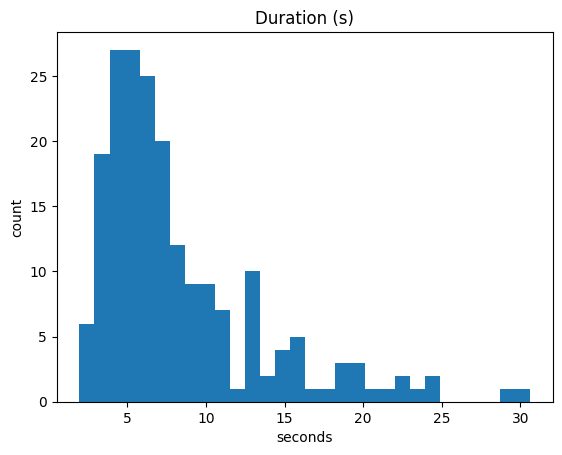

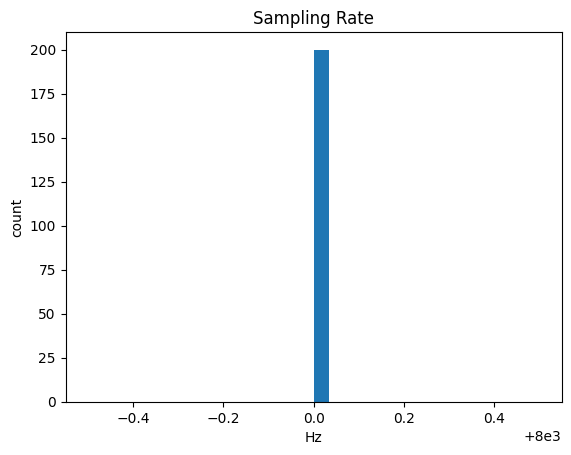

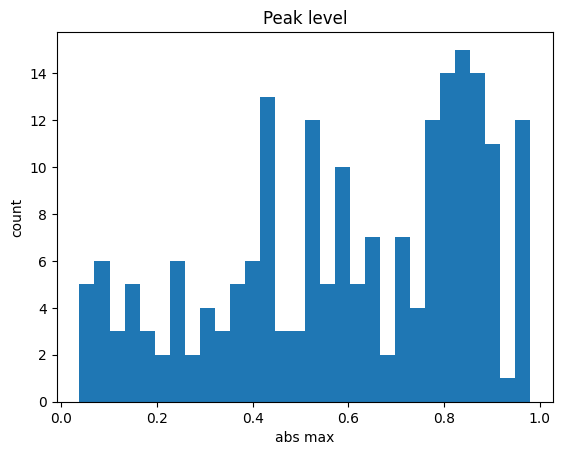

In [13]:

# TODO-5.1: гистограммы и распределения
def hist(values, bins=30, title="Histogram", xlabel="value"):
    import matplotlib.pyplot as plt
    plt.figure()
    plt.hist(values, bins=bins)
    plt.title(title); plt.xlabel(xlabel); plt.ylabel("count"); plt.show()

if metrics:
    hist([m['dur_s'] for m in metrics if m.get('dur_s') is not None], title="Duration (s)", xlabel="seconds")
    hist([m['sr'] for m in metrics if m.get('sr') is not None], title="Sampling Rate", xlabel="Hz")
    hist([m['peak'] for m in metrics if m.get('peak') is not None], title="Peak level", xlabel="abs max")
